In [62]:
import copy
from time import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from GradBoost import GradBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor as SKBoost
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [63]:
df = pd.read_csv('../data/Clean_Dataset.csv')[:5000]
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('flight', axis=1)

df['class'] = df['class'].apply(lambda x: 1 if x == 'Business' else 0)
df.stops = pd.factorize(df.stops)[0]
df = df.join(pd.get_dummies(df.airline, prefix='airline')).drop('airline', axis=1)
df = df.join(pd.get_dummies(df.source_city, prefix='source_city')).drop('source_city', axis=1)
df = df.join(pd.get_dummies(df.destination_city, prefix='destination_city')).drop('destination_city', axis=1)
df = df.join(pd.get_dummies(df.arrival_time, prefix='arrival_time')).drop('arrival_time', axis=1)
df = df.join(pd.get_dummies(df.departure_time, prefix='departure_time')).drop('departure_time', axis=1)
X = df.drop(['price'], axis=1).to_numpy()
y = df['price'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape

((4000, 24), (4000,))

In [64]:
def MSE(y, y_pred):
    return 1/len(y) * 0.5 * np.sum(np.square(y-y_pred))

def grad_MSE(y, y_pred):
    return -(y-y_pred)

In [65]:
ensemble1 = GradBoostRegressor(MSE, grad_MSE, lr=0.05)

start1 = time()
ensemble1.fit(X_train, y_train.reshape(-1, 1))
end1 = time()

y_pred = ensemble1.predict(X_test)
print(f"Число итераций: {ensemble1.num_iterations}")
print(f"R2: {r2_score(y_test, y_pred):.3f}")

Число итераций: 1000
R2: 0.816


In [66]:
ensemble2 = SKBoost(n_estimators=1000, n_iter_no_change=5)

start2 = time()
ensemble2.fit(X_train, y_train)
end2 = time()

y_pred_sk = ensemble2.predict(X_test)
print(f"R2: {r2_score(y_test, y_pred_sk):.3f}")

R2: 0.793


Text(0.5, 1.0, 'График функции потерь')

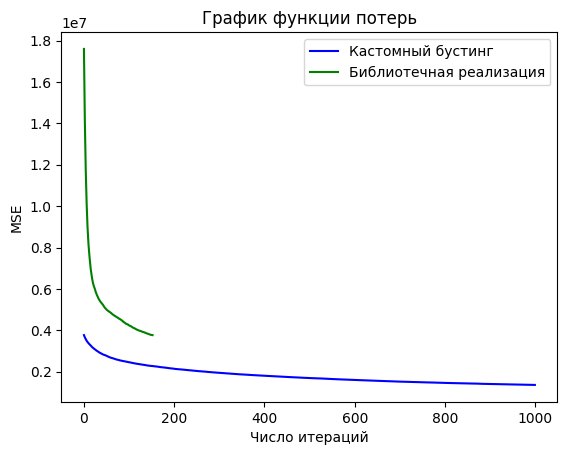

In [67]:
plt.plot(ensemble1.losses, c='blue', label="Кастомный бустинг")
plt.plot(ensemble2.train_score_, c='green', label='Библиотечная реализация')
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Число итераций")
plt.title("График функции потерь")

In [68]:
print(f"Время работы кастомного алгоритма при {ensemble1.num_iterations} итерациях: {(end1 - start1):.2f} с")
print(f"Время обучения библиотечной реализации при {ensemble2.n_estimators_} итерациях: {(end2 - start2):.2f} с")

Время работы кастомного алгоритма при 1000 итерациях: 14.06 с
Время обучения библиотечной реализации при 153 итерациях: 0.53 с


In [69]:
def cross_validate(model, X, y, n_folds=5):
    scores = []
    for n in range(n_folds):
        model2fit = copy.deepcopy(model)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model2fit.fit(X_train, y_train)
        scores += [r2_score(y_test, model2fit.predict(X_test))]
    return scores

In [72]:
n_folds = 20

ensemble1 = GradBoostRegressor(MSE, grad_MSE, lr=0.05, max_depth=3)
ensemble2 = SKBoost(n_estimators=1000, n_iter_no_change=5)

custom_scores = cross_validate(ensemble1, X, y, n_folds=n_folds)
sklearn_scores = cross_validate(ensemble2, X, y, n_folds=n_folds)

In [73]:
print(f"Среднее R2-score для {n_folds} выборок у кастомного алгоритма: {np.mean(custom_scores):.3f}")
print(f"Среднее R2-score для {n_folds} выборок у библиотечного алгоритма: {np.mean(sklearn_scores):.3f}")

Среднее R2-score для 20 выборок у кастомного алгоритма: 0.810
Среднее R2-score для 20 выборок у библиотечного алгоритма: 0.769
